<a href="https://colab.research.google.com/github/khoji-code/Data-Analysis/blob/main/Time_Series_Forecasting_for_Bike_Share_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Time-Series Forecasting for Bike Share Demand

### **Project Overview**

* **Goal:** To develop a high-accuracy machine learning model to forecast the hourly demand for bike rentals.
* **Dataset:** Utilizes the UCI Bike Sharing dataset, which contains two years of hourly rental data along with weather and seasonal information.
* **Methodology:** The project features an in-depth exploratory data analysis (EDA) with time-series decomposition and circadian rhythm heatmaps to uncover rental patterns. Advanced feature engineering is employed, creating lag and rolling window features to capture temporal dependencies. A LightGBM Regressor is trained on 2011 data and tested on 2012 data to simulate a real-world forecasting scenario.
* **Key Results:** The model demonstrates strong predictive performance, achieving an R-squared (R²) of **0.751** on the unseen 2012 test data. Feature importance analysis highlights that the hour of the day and recent rental counts (lag features) are the most significant predictors.

***

### **Purpose**

* **Optimize Bike Availability:** To create a reliable forecasting model that helps bike-sharing companies optimize the supply and distribution of bikes, ensuring they are available when and where customers need them most.
* **Inform Operational Decisions:** To provide data-driven insights that can guide operational decisions, such as maintenance schedules and staff allocation, based on predicted demand patterns.
* **Understand Demand Drivers:** To identify the key factors—such as time of day, weather conditions, and seasonality—that influence bike rental demand, allowing for better strategic planning and resource management.

### Dataset:
https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset

## IMPORT LIBRARIES

In [1]:
# Install LightGBM
!pip install -q lightgbm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

# Explain: Ignore warnings for a cleaner output during analysis.
warnings.filterwarnings('ignore')
print("Libraries imported successfully.")

Libraries imported successfully.


## LOAD AND PREPARE DATA

In [10]:
try:
    df = pd.read_csv('/content/drive/MyDrive/bike/hour.csv')
    print("Dataset loaded successfully. Shape:", df.shape)
except FileNotFoundError:
    print("Error: 'hour.csv' not found. Please upload the file to your Colab session.")
    exit()

Dataset loaded successfully. Shape: (17379, 17)


### Data Cleaning and Type Conversion

In [11]:
# 'dteday' is converted to a datetime object, which is crucial for time series analysis.
df['dteday'] = pd.to_datetime(df['dteday'])

# Rename columns for better readability and consistency.
df.rename(columns={'dteday': 'datetime', 'yr': 'year', 'mnth': 'month', 'hr': 'hour',
                   'weathersit': 'weather_condition', 'hum': 'humidity', 'cnt': 'count'}, inplace=True)

df = df.drop(['instant', 'casual', 'registered'], axis=1)

print("\nData prepared. New shape:", df.shape)
print("\nData Head:")
print(df.head())




Data prepared. New shape: (17379, 14)

Data Head:
    datetime  season  year  month  hour  holiday  weekday  workingday  \
0 2011-01-01       1     0      1     0        0        6           0   
1 2011-01-01       1     0      1     1        0        6           0   
2 2011-01-01       1     0      1     2        0        6           0   
3 2011-01-01       1     0      1     3        0        6           0   
4 2011-01-01       1     0      1     4        0        6           0   

   weather_condition  temp   atemp  humidity  windspeed  count  
0                  1  0.24  0.2879      0.81        0.0     16  
1                  1  0.22  0.2727      0.80        0.0     40  
2                  1  0.22  0.2727      0.80        0.0     32  
3                  1  0.24  0.2879      0.75        0.0     13  
4                  1  0.24  0.2879      0.75        0.0      1  


## EXPLORATORY DATA ANALYSIS (EDA)

## Time Series Decomposition

<Figure size 1400x1000 with 0 Axes>

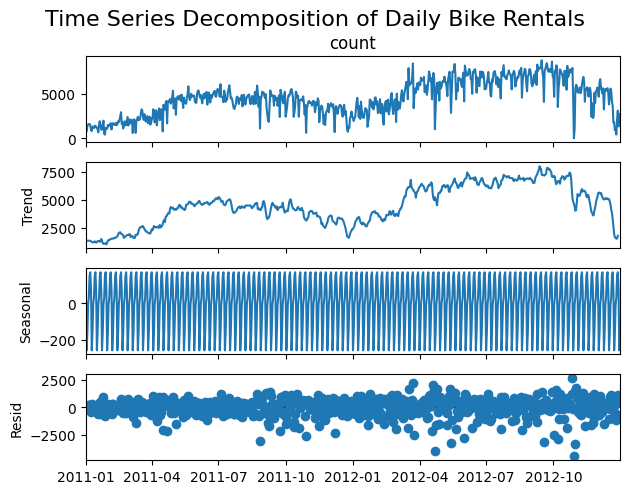

In [13]:
# - Trend: Shows the long-term growth in bike rentals.
# - Seasonal: Shows the regular, repeating patterns within a year (e.g., higher in summer).
# - Residual: The noise or random fluctuations in the data.
daily_data = df.set_index('datetime').resample('D')['count'].sum()
decomposition = seasonal_decompose(daily_data, model='additive')

plt.figure(figsize=(14, 10))
decomposition.plot()
plt.suptitle('Time Series Decomposition of Daily Bike Rentals', y=1.02, fontsize=16)
plt.show()

## Circadian Rhythm Heatmap (Hour vs. Weekday)

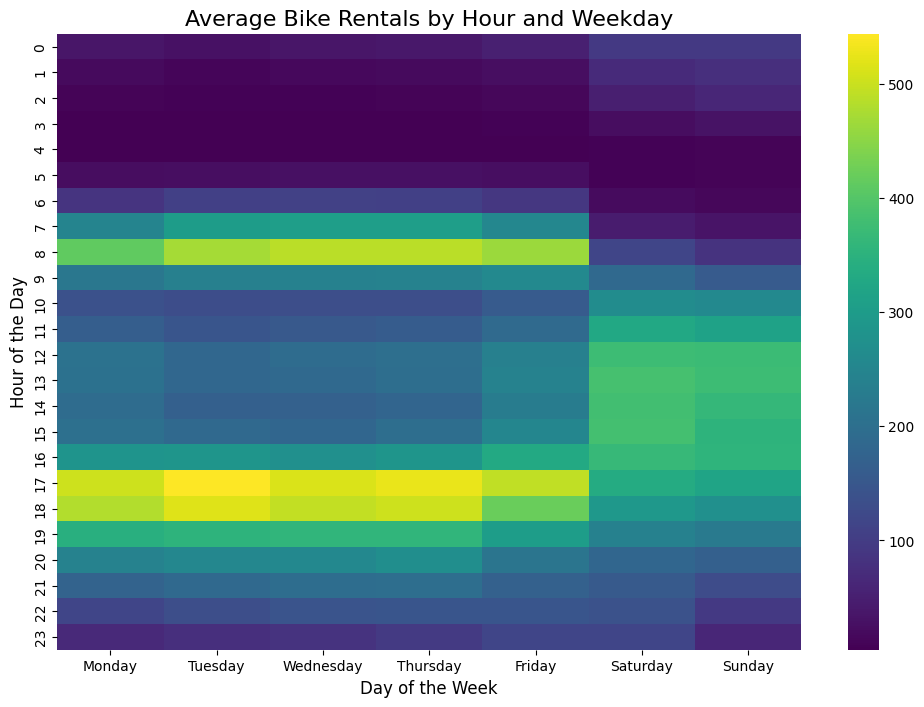

In [15]:
df['weekday'] = df['datetime'].dt.day_name()
heatmap_data = df.pivot_table(index='hour', columns='weekday', values='count', aggfunc='mean')
# Order the columns by day of the week
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data[weekday_order]

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=False)
plt.title('Average Bike Rentals by Hour and Weekday', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Hour of the Day', fontsize=12)
plt.show()

## Weather Impact Matrix

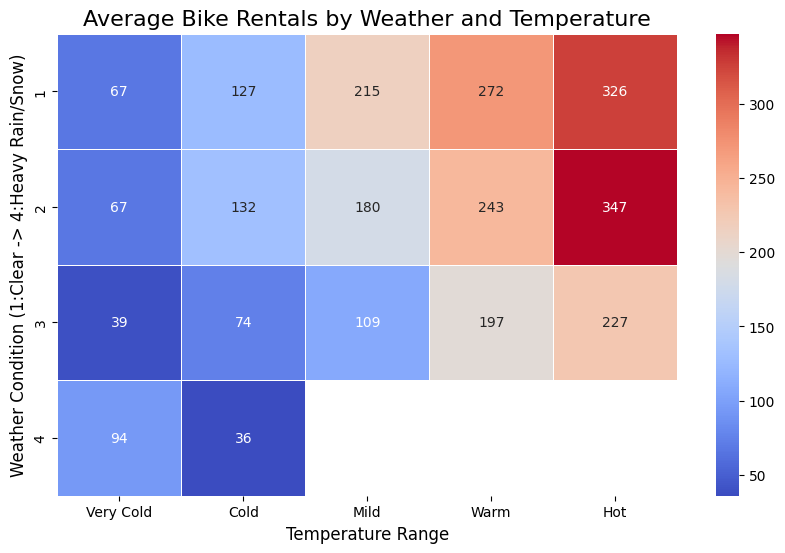

In [16]:
df['temp_binned'] = pd.cut(df['temp'], bins=5, labels=['Very Cold', 'Cold', 'Mild', 'Warm', 'Hot'])
weather_impact = df.pivot_table(index='weather_condition', columns='temp_binned', values='count', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(weather_impact, cmap='coolwarm', annot=True, fmt=".0f", linewidths=.5)
plt.title('Average Bike Rentals by Weather and Temperature', fontsize=16)
plt.xlabel('Temperature Range', fontsize=12)
plt.ylabel('Weather Condition (1:Clear -> 4:Heavy Rain/Snow)', fontsize=12)
plt.show()

## ADVANCED FEATURE ENGINEERING FOR TIME SERIES

In [17]:
# Sort the data by datetime to ensure our time-series features are correct.
df = df.sort_values('datetime').set_index('datetime')

# Lag Features
# Create features representing the bike count from previous hours.
# This is crucial as recent demand is a very strong predictor of future demand.
# We shift the 'count' column down by 1, 2, and 3 rows to get the values from past hours.
for i in range(1, 4):
    df[f'lag_{i}h'] = df['count'].shift(i)

# Rolling Window Features
# Calculate the average count over a 24-hour rolling window.
# This helps the model understand the recent trend and smooths out short-term noise.
df['rolling_mean_24h'] = df['count'].rolling(window=24).mean()

# Drop rows as they cannot be used for training.
df.dropna(inplace=True)
print("Lag and rolling features created. New shape:", df.shape)

Lag and rolling features created. New shape: (17356, 18)


## MODEL TRAINING & EVALUATION

In [18]:
# Chronological Data Split
train_df = df[df['year'] == 0]
test_df = df[df['year'] == 1]

# Drop the original 'datetime' column and other non-feature columns
features = [col for col in df.columns if col not in ['count', 'datetime', 'weekday', 'temp_binned']]
X_train = train_df[features]
y_train = train_df['count']
X_test = test_df[features]
y_test = test_df['count']

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (8622, 15)
Test data shape: (8734, 15)


## Train the LightGBM Model

In [19]:
# `objective='regression_l1'` (MAE) is often more robust to outliers than standard MSE.
lgbm = lgb.LGBMRegressor(
    objective='regression_l1',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

print("Training the LightGBM model...")
lgbm.fit(X_train, y_train,
         eval_set=[(X_test, y_test)],
         eval_metric='mae',
         callbacks=[lgb.early_stopping(100, verbose=False)])
print("Model training completed.")

Training the LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1288
[LightGBM] [Info] Number of data points in the train set: 8622, number of used features: 14
[LightGBM] [Info] Start training from score 110.000000
Model training completed.


## Evaluate the Model

In [21]:
# Make predictions on the 2012 test data
y_pred = lgbm.predict(X_test)

# - R-squared (R²): Proportion of variance in the target predictable from the features. Higher is better.
# - MAE: Average absolute difference between predicted and actual values.
# - RMSE: Square root of the average of squared differences. Punishes large errors more.
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n--- Model Evaluation on 2012 Test Data ---")
print(f"R-squared (R²): {r2:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


--- Model Evaluation on 2012 Test Data ---
R-squared (R²): 0.751
Mean Absolute Error (MAE): 67.31
Root Mean Squared Error (RMSE): 104.15


## VISUALIZE RESULTS

### Actual vs. Predicted Plot

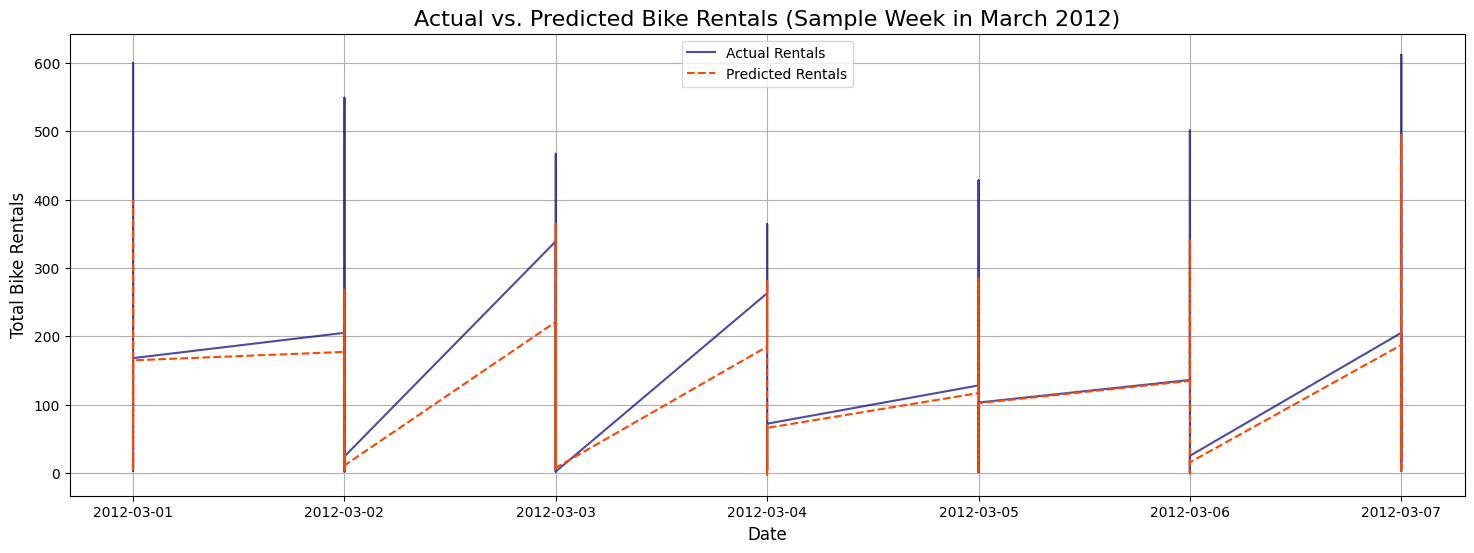

In [22]:
plt.figure(figsize=(18, 6))
# Plotting for the first week of March 2012
sample_period = (X_test.index >= '2012-03-01') & (X_test.index < '2012-03-08')
plt.plot(X_test.index[sample_period], y_test[sample_period], label='Actual Rentals', color='navy', alpha=0.7)
plt.plot(X_test.index[sample_period], y_pred[sample_period], label='Predicted Rentals', color='orangered', linestyle='--')
plt.title('Actual vs. Predicted Bike Rentals (Sample Week in March 2012)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Bike Rentals', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

### Feature Importance Plot

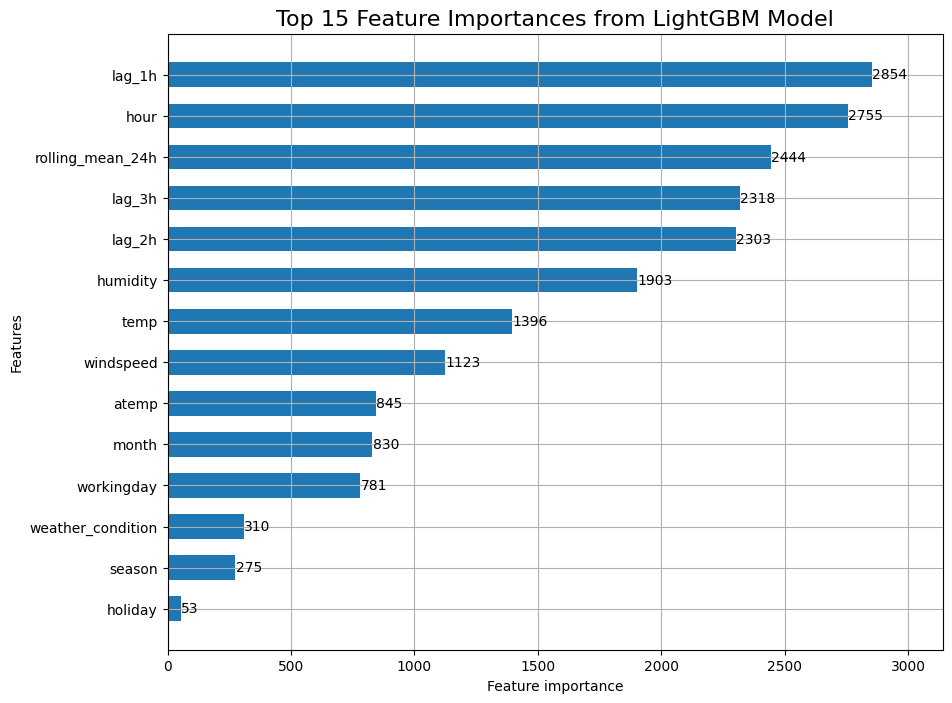

In [24]:
lgb.plot_importance(lgbm, height=0.6, figsize=(10, 8), max_num_features=15)
plt.title('Top 15 Feature Importances from LightGBM Model', fontsize=16)
plt.show()